# Ridge regression

### Also know as weight decay. While analysing, multiple regression suffers colinearity where mean squares is unbaised. A weight method is used that reduces the weights with a learning rate. And finally comeup with the most optimal coefficients. Ridge regression is implemented using Batch Gradient descent and Stochastic Gradient Descent algorithms

### Below is the weight decay formual

<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n - \eta\lambda\pmb{w}^{(\tau)} $</li>

Below tasks are carried out - 

i.  Implement Stochastic Gradient Descent algorithm (SDG)

ii. Implement Batch Gradient Descent algorithm (BDG)

iii.Plot data points visited vs error rate

iv. Report

In [90]:
# importing required libraries
library(ggplot2)
library(reshape2)

In [91]:
# loading train and test data
train = read.csv(file='Task1C_train.csv')
test = read.csv(file='Task1C_test.csv')

#scaling data to reduces the data values.
train = scale(train)
test = scale(test)

head(train)
head(test)
dim(train)

x1,x2,x3,x4,y
-1.729259,-0.8314871,-1.0209430,-0.7844105,-1.148323
-1.725536,-0.8520287,-1.0206420,-0.8790979,-1.143610
-1.721813,-0.8412684,-1.0158255,-0.8702858,-1.106215
-1.718090,-0.8296399,-1.0180531,-0.8505881,-1.102936
-1.714368,-0.8252803,-1.0092629,-0.8168945,-1.079782
-1.710645,-0.8138550,-0.9934286,-0.8068729,-1.057242


x1,x2,x3,x4,y
-1.729259,-0.8447954,-1.0144788,-0.8216982,-1.131671
-1.725536,-0.8379815,-1.0171199,-0.8945270,-1.121240
-1.721813,-0.8475725,-1.0246229,-0.8838775,-1.124921
-1.718090,-0.8203904,-1.0054151,-0.8098463,-1.082381
-1.714368,-0.8151305,-0.9977921,-0.8151711,-1.093630
-1.710645,-0.8220640,-0.9892686,-0.8131099,-1.032887


[1] 930   5

In [92]:
# splitting x and y variables
train.data = train[,-5]
train.y = train[,5]
test.data = test[,-5]
test.y = test[,5]

In [93]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func = function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate a cost function
error_func = function (Phi,w, label,train.len){
    return(sum((predict_func(Phi, w) - label)^2)/train.len)
}

#### i. Implementing SDG function
For each data point weights are updated and error is calculated for that data point.

inputs - training data , training label , testing data , testing label, iterations ,learning rate and lambda(generalization factor)

Otput - Error rate

In [116]:
SDG = function(train.data,train.y,test.data,test.y,iterations = 18 ,learning.rate = 0.01,lambda = 0.1){
    
    train.len = nrow(train.data)
    test.len = nrow(test.data)
    t.max = iterations*train.len
    y = train.y
    
    
    # variables required for the process
    phiSDG = as.matrix(cbind('x0'=1,train.data)) # basis function
    wSDG = matrix(,nrow = t.max,ncol = ncol(phiSDG)) # weight dataframe to store all the weight for every update
    wSDG[1,] = runif(ncol(phiSDG)) # intialising weights as random (0,1) values 
    #error data frame
    error = data.frame('t'=1:t.max) 
    epsilon = 0.1*mean(train.y) # to terminate the SDG process if error is less than epsilon
    t = 1# to keep track of data points covered.
    stop = FALSE
    
    
    #main SDG Loop
    
    while(!stop){
        
        stop = t >= t.max | error_func(phiSDG, wSDG[t,],train.y,train.len)<=epsilon
        
        # shuffling the training data, so does phi function
        train.index = sample(1:train.len,train.len,replace=F)
        phiSDG = phiSDG[train.index,]
        y = y[train.index]

        # for each row in training data
        for (i in 1:train.len){
            # if terminating quality is met, stop is made true
            if(t >= t.max | error_func(phiSDG, wSDG[t,],y,train.len)<=epsilon){stop = TRUE;break}
            
            # calculate training and testing errors for each update in weights
            error [t,'train'] = error_func(as.matrix(cbind(1,train.data)), wSDG[t,], train.y,train.len)
            error [t,'test'] = error_func(as.matrix(cbind(1,test.data)), wSDG[t,], test.y,train.len)
            
            
            #prediciting label using the lated weight
            t_pred = predict_func(phiSDG[i,], wSDG[t,])
            
            # for each column of phi
            for (j in 1:ncol(wSDG)){
                
                # update the weights using the above mentioned formula
                fwSDG[(t+1),j] = wSDG[t,j] + learning.rate*((y[i] - t_pred)*phiSDG[i,j]) - learning.rate*lambda*wSDG[t,j]
            }
            
            # increment of iterations 
            t=t+1
            
        }
    }
    
    # calculating the errors for last iteration
    error [nrow(error),'train'] = error_func(as.matrix(cbind(1,train.data)), wSDG[t.max,], train.y,train.len)
    error [nrow(error),'test'] = error_func(as.matrix(cbind(1,test.data)), wSDG[t.max,], test.y,test.len)
            

    # result is
    cat("\nStochastic Decent Gradient\n")
    cat("coefficients are :", wSDG[t,])
    cat("\n\nerror with these coefficients are \n train :" , error[t-1,2],"\n test  :",error[t-1,3])
    return(error)
}

#### i. Implementing BDG function
Weights are updated on considering the entire data and error is calculated for the entire data using these weights.

inputs - training data , training label , testing data , testing label, iterations ,learning rate and lambda(generalization factor)

Otput - Error rate

In [117]:
BDG = function(train.data,train.y,test.data,test.y,iterations = 18 ,learning.rate = 0.01,lambda = 0.1){
    
    train.len = nrow(train.data)
    test.len = nrow(test.data)
    t.max = iterations
    y = train.y
    phiBDG = as.matrix(cbind('x0'=1,train.data))  # basis function
    wBDG = matrix(,nrow = t.max,ncol = ncol(phiBDG)) # weight dataframe to store all the weight for every update
    wBDG[1,] = runif(ncol(phiBDG)) # intialising weights as random (0,1) values
    error = data.frame('t'=1:t.max) # error data frame
    epsilon = 0.1*mean(train.y)  # to terminate the SDG process if error is less than epsilon
    stop = FALSE
    t=1 # to keep track of data points covered. 
    
    while(!stop){
        
        # shuffling the training data, so does the basis functions
        train.index = sample(1:train.len,train.len,replace=F)
        phiBDG = phiBDG[train.index,]
        y = y[train.index]


        # For each iteration 
        for (i in 1:t.max){
            if(i >= t.max | error_func(phiBDG, wBDG[i,],y,train.len)<=epsilon){stop = TRUE;break}
            
            # training and testing errors are calculated using the auxilary function, error_func
            error [i,'train'] = error_func(as.matrix(cbind(1,train.data)), wBDG[i,], train.y,train.len)
            error [i,'test'] = error_func(as.matrix(cbind(1,test.data)), wBDG[i,], test.y,test.len)
            
            # error is calculated using the latest weigths
            err = y - predict_func(phiBDG, wBDG[i,])
            
            # for each column of basis function
            for (j in 1:ncol(wBDG)){
                
                wBDG[(i+1),j] = wBDG[i,j] + learning.rate*(t(err)%*%phiBDG[,j])/train.len - learning.rate*lambda*wBDG[i,j]
            }
            
            # changing the learning rate
            learning.rate = learning.rate/2
            
            #increment the iteration
            t=t+1

        }
    }
    
    # calculating the errors for last iteration
    error[nrow(error),'train'] = error_func(as.matrix(cbind(1,train.data)), wBDG[nrow(wBDG),], train.y,train.len)
    error[nrow(error),'test'] = error_func(as.matrix(cbind(1,test.data)), wBDG[nrow(wBDG),], test.y,test.len)

    # printing the final weights
    cat("\n------------\nBatch Decent Gradient\n")
    cat("coefficients are :", wBDG[t.max,])
    cat("\n\nerror with these coefficients are \n train :" , error[t.max-1,2],"\n test  :",error[t.max-1,3])
    return(error)
}

### Calling the functions to get the error rates for each 

In [118]:
iterations = 18
learning.rate = 0.01
lambda = 0.01

errorSDG = SDG(train.data,train.y,test.data,test.y,iterations ,learning.rate, lambda)
errorBDG = BDG(train.data,train.y,test.data,test.y,iterations ,learning.rate, lambda)


Stochastic Decent Gradient
coefficients are : 0.006716 0.2744792 0.1500811 0.5061245 0.1089622

error with these coefficients are 
 train : 0.01420765 
 test  : 0.01444256
------------
Batch Decent Gradient
coefficients are : 0.09146017 0.09862694 0.3587436 0.3697052 0.6540408

error with these coefficients are 
 train : 0.2930727 
 test  : 0.2939263

In [119]:
tail(errorSDG)
tail(errorBDG)

,t,train,test
16735,16735,0.01418134,0.01441674
16736,16736,0.01415938,0.01439377
16737,16737,0.01415110,0.01438540
16738,16738,0.01416689,0.01440137
16739,16739,0.01420765,0.01444256
16740,16740,0.01421661,0.01445090


,t,train,test
13,13,0.2930797,0.2939333
14,14,0.2930760,0.2939296
15,15,0.2930741,0.2939277
16,16,0.2930732,0.2939268
17,17,0.2930727,0.2939263
18,18,0.2930725,0.2939261


### Ploting the error rate for each algorithm

Warning message in par(new = TRUE):
"calling par(new=TRUE) with no plot"

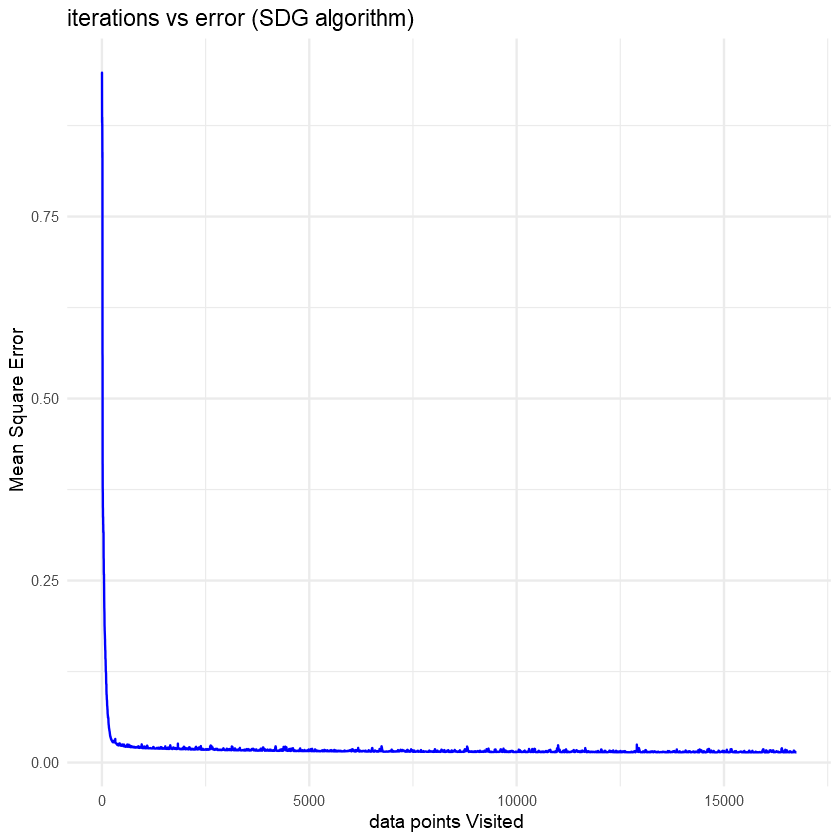

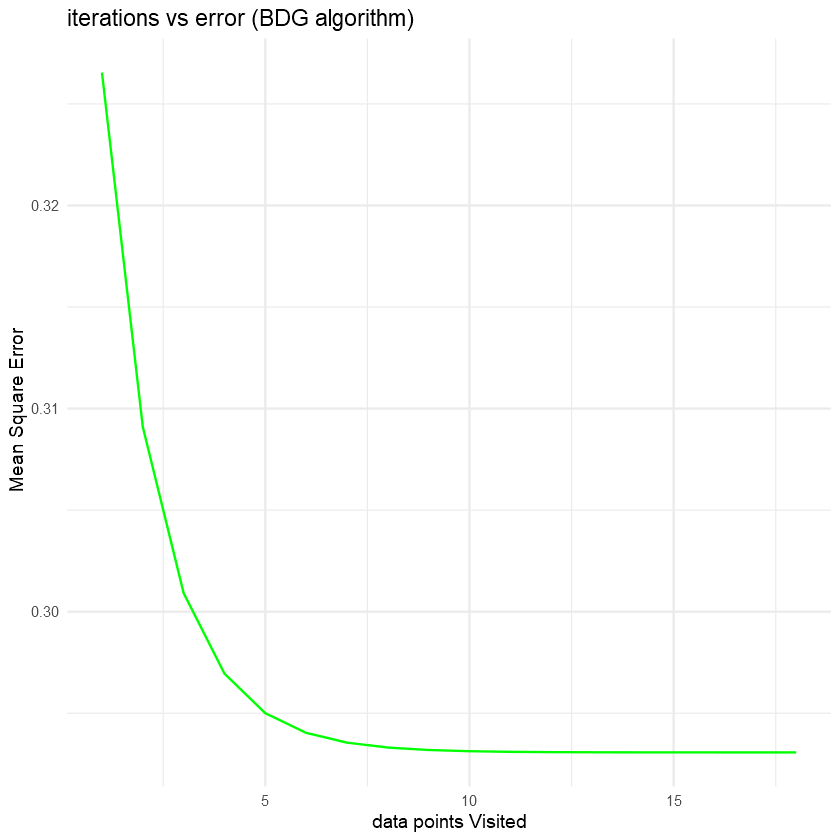

In [120]:
# plot for SDG
p1 = ggplot(aes(t,train),data = errorSDG) + geom_line(color = 'blue')+ theme_minimal() +
       ggtitle("iterations vs error (SDG algorithm)") + xlab("data points Visited ") + ylab("Mean Square Error")

# plot for BDG
p2 = ggplot(aes(t,train),data = errorBDG) + geom_line(color = 'green')+ theme_minimal() +
       ggtitle("iterations vs error (BDG algorithm)") + xlab("data points Visited") + ylab("Mean Square Error")

p1
par(new=TRUE)
p2

In [121]:
# To match with the iterations of the SDG 
errorBDG$t = errorBDG$t * nrow(train.data)
tail(errorBDG)

,t,train,test
13,12090,0.2930797,0.2939333
14,13020,0.2930760,0.2939296
15,13950,0.2930741,0.2939277
16,14880,0.2930732,0.2939268
17,15810,0.2930727,0.2939263
18,16740,0.2930725,0.2939261


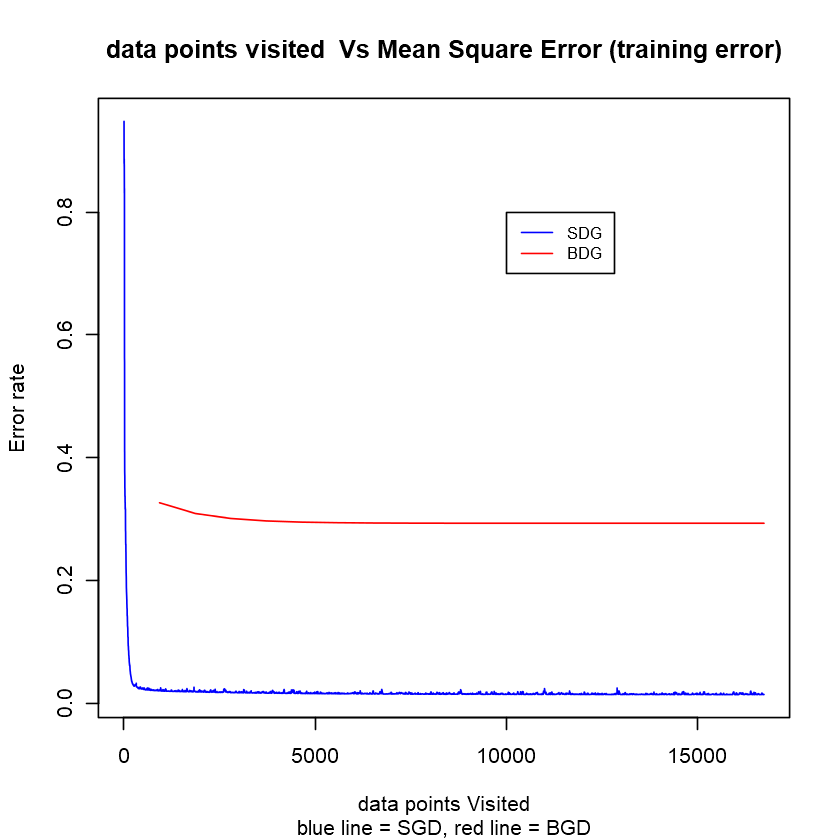

In [132]:
# plotting SDG
plot(errorSDG[,1], errorSDG[,2], type="l", col="blue", 
     xlab="data points Visited", ylab="Error rate", main = "data points visited  Vs Mean Square Error (training error)", 
     sub = "blue line = SGD, red line = BGD")

# ploting the BDG error
lines(errorBDG[,1], errorBDG[,2], type="l", col="red")

# adding legend
legend(10000, 0.8, legend=c("SDG", "BDG"),
       col=c("blue", "red"), lty=1, cex=0.8)

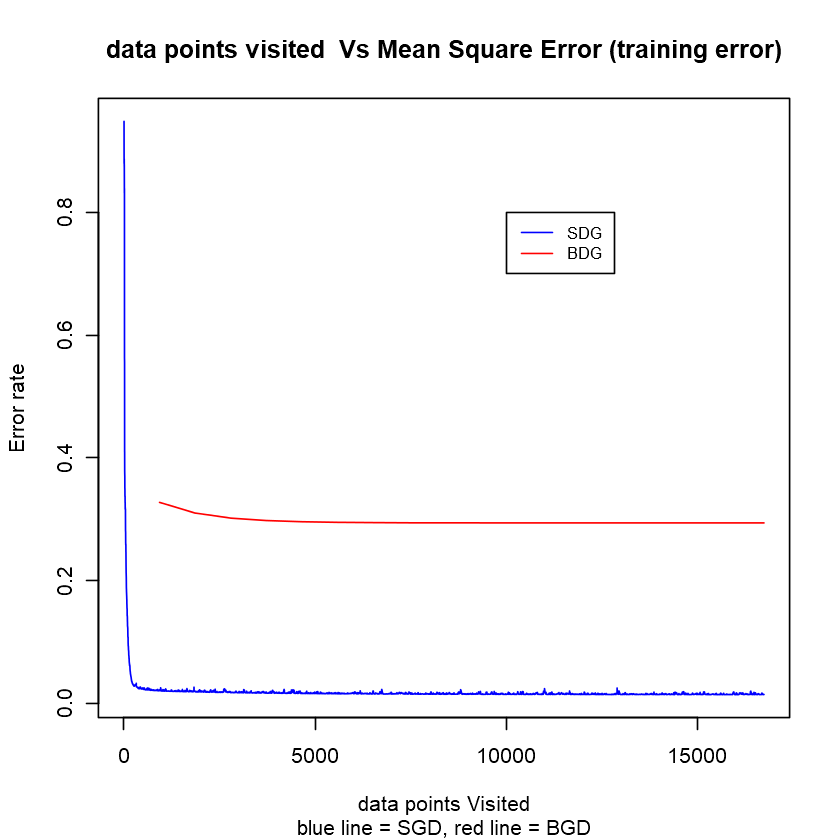

In [133]:
# Testing Error
# plotting SDG
plot(errorSDG[,1], errorSDG[,3], type="l", col="blue", 
     xlab="data points Visited", ylab="Error rate", main = "data points visited  Vs Mean Square Error (training error)", 
     sub = "blue line = SGD, red line = BGD")

# ploting the BDG error
lines(errorBDG[,1], errorBDG[,3], type="l", col="red")

# adding legend
legend(10000, 0.8, legend=c("SDG", "BDG"),
       col=c("blue", "red"), lty=1, cex=0.8)

### Report
SDG convergese much quicker than BDG.
The error of the BDG is quite high when compared with SDG. More iterations are required to obtain the optimal solution using BDG. Whereas SDG shows good results on few iterations(as it considers every point of the data). However SDG algorithm required more time to execute.